# Modeling Crop Yield
## Python modules

In [1]:
import warnings
import time
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import geopandas

import pyarrow
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from scipy.stats import spearmanr
from scipy.linalg import LinAlgWarning
from scipy.stats import pearsonr

import math
import seaborn as sns

## Parameters
Choose a satellite

In [2]:
satellite = "landsat-8-c2-l2"
# satellite = "sentinel-2-l2a"

Choose band combination

In [3]:
# bands = "2-3-4"
# bands = "2-3-4-8"
bands = "1-2-3-4-5-6-7"

Choose the number of points that were featurized

In [4]:
# points = "4"
points = "15"
# points = "24"
# points = "42"

Choose keep only areas with crops (True) or to keep all points (False)

In [5]:
# crop_mask = True
crop_mask = False

Impute NA values by descending group levels (True) or scikit learn's simple imputer (False)

In [6]:
impute_manual = True
# impute_manual = False

Choose a weighted average (True) or a simple mean (False) to use when collapsing features to administrative boundary level.

In [7]:
# weighted_avg = True
weighted_avg = False

Choose which months to use in the model. Note that months 10, 11, and 12 get pushed to the next year because growing season spans the calendar year. 

In [8]:
# month_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
# month_range = [      3, 4, 5, 6, 7, 8, 9            ]
month_range = [         4, 5, 6, 7, 8, 9            ]
# month_range = [            5, 6, 7, 8, 9            ]
# month_range = [         4, 5, 6, 7, 8               ]
# month_range = [            5, 6, 7, 8               ]

### Unchanging parmaters
Less frequently changing at least

In [9]:
country_code = "ZMB"
num_features = 1000

if satellite == "landsat-8-c2-l2":
    year_start = 2013 # Landsat
else:
    year_start = 2015 # Sentinel
year_end = 2018

taylor_data_dir = "/capstone/cropmosaiks/data"  
feature_file_name = (f'{satellite}_bands-{bands}_{country_code}_{points}k-points_{num_features}-features')
weight_file_name = (f'{country_code}_crop_weights_{points}k-points')

if points == "4":
    marker_sz = 60
elif points == "15":
    marker_sz = 15
elif points == "24":
    marker_sz = 10
else:
    marker_sz = 8

## Administrative boundaries 

<AxesSubplot:>

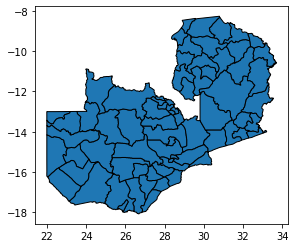

In [10]:
country_shp = geopandas.read_file(f'{taylor_data_dir}/boundaries/gadm36_{country_code}_2.shp')
country_shp = country_shp.rename(columns = {'NAME_2': 'district'})[['district', 'geometry']]
country_shp.district = country_shp.district.replace("MPongwe", 'Mpongwe', regex=True)
country_districts = country_shp.district.sort_values().unique().tolist()
country_shp = country_shp.set_index('district')
country_shp.shape
country_shp.plot(linewidth = 1, edgecolor = 'black' )
# country_shp.plot()

## Crop yield

In [11]:
crop_df = pd.read_csv(taylor_data_dir+'/crops/cfs_maize_districts_zambia_2009_2018.csv')
crop_df.district = crop_df.district.replace(
    {"Itezhi-tezhi": 'Itezhi-Tezhi',
     "Kapiri-Mposhi": 'Kapiri Mposhi',
     "Shang'ombo": 'Shangombo',
     "Chienge": 'Chiengi'
    }, regex=True)
crop_districts = crop_df.district.sort_values().unique().tolist()
crop_df = crop_df[['district', 'year', 'yield_mt']]
ln = len(crop_df[crop_df.year == 2016].district)
crop_df = crop_df.set_index('district')
ln
# crop_df

74

In [12]:
list(set(crop_districts) - set(country_districts))

['Ikelenge', 'Mafinga']

In [13]:
list(set(country_districts) - set(crop_districts))

[]

In [14]:
country_crop = geopandas.GeoDataFrame(crop_df.join(country_shp), crs = country_shp.crs)

## Crop land

In [15]:
weights = pd.read_feather(f"{taylor_data_dir}/weights/{weight_file_name}.feather")
# weights

<AxesSubplot:>

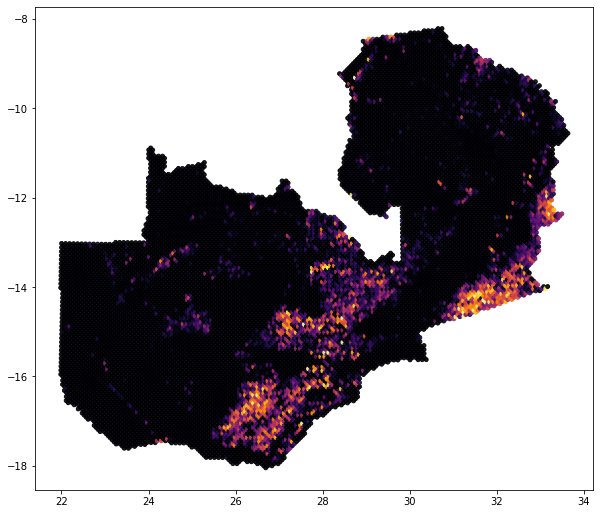

In [16]:
weights_gdf = geopandas.GeoDataFrame(
    weights, 
    geometry = geopandas.points_from_xy(x = weights.lon, y = weights.lat), 
    crs='EPSG:4326'
)
weights_gdf.plot(figsize = (10,10),
                 cmap = 'inferno',
                 markersize = marker_sz,
                 alpha = .9,
                 column = 'crop_perc')
# plt.axis('off')

In [17]:
weights.crop_perc = weights.crop_perc.fillna(0)
# #weights.crop_perc = weights.crop_perc + 0.0001

## Features

In [18]:
features_raw = geopandas.GeoDataFrame()

for yr in range(year_start, year_end + 1):
    print(f"Opening: {feature_file_name}_{yr}.feather")
    features_x = pd.read_feather(f"{taylor_data_dir}/features/{feature_file_name}_{yr}.feather")
    
    if (yr == 2013) & (satellite == "landsat-8-c2-l2"):
        features_x = features_x[features_x.month > 9]
    elif (yr == 2015) & (satellite == "sentinel-2-l2a"):
        features_x = features_x[features_x.month > 9]
    else:
        pass
    
    # concatenate the feather files together, axis = 0 specifies to stack rows (rather than adding columns)
    features_raw = pd.concat([features_raw, features_x], axis=0)
    
    print("feature.shape", features_raw.shape)
    print("Appending:", yr)
    print("")

Opening: landsat-8-c2-l2_bands-1-2-3-4-5-6-7_ZMB_15k-points_1000-features_2013.feather
feature.shape (20292, 1004)
Appending: 2013

Opening: landsat-8-c2-l2_bands-1-2-3-4-5-6-7_ZMB_15k-points_1000-features_2014.feather
feature.shape (127902, 1004)
Appending: 2014

Opening: landsat-8-c2-l2_bands-1-2-3-4-5-6-7_ZMB_15k-points_1000-features_2015.feather
feature.shape (249734, 1004)
Appending: 2015

Opening: landsat-8-c2-l2_bands-1-2-3-4-5-6-7_ZMB_15k-points_1000-features_2016.feather
feature.shape (369929, 1004)
Appending: 2016

Opening: landsat-8-c2-l2_bands-1-2-3-4-5-6-7_ZMB_15k-points_1000-features_2017.feather
feature.shape (469582, 1004)
Appending: 2017

Opening: landsat-8-c2-l2_bands-1-2-3-4-5-6-7_ZMB_15k-points_1000-features_2018.feather
feature.shape (583760, 1004)
Appending: 2018



In [19]:
features = features_raw.copy()

In [20]:
features['year'] = np.where(
    features['month'].isin([10, 11, 12]),
    features['year'] + 1, 
    features['year'])

features = features[features['year'] <= year_end]

features.sort_values(['year', 'month'], inplace=True)

### Filter month range

In [21]:
features = features[features.month.isin(month_range)]

### Pivot wider
Here we pivot the data from long format to wide by indexing on 'lon','lat', "year", 'month' and using the unstack function. We then map column names based on the month index and the associated features so month '01' is appended to each feature for that month making 0_01, 1_01 etc. 

In [22]:
features = features.set_index(['lon','lat', "year", 'month']).unstack()
features.columns = features.columns.map(lambda x: '{}_{}'.format(*x))

### Replace "inf" values with NaN

In [23]:
features.replace([np.inf, -np.inf], np.nan, inplace=True)
features = features.reset_index()
# features

### Attach crop weights
Attach weight to each point (% area cropped of surrounding 1 km^2).

In [24]:
features = features.join(weights.set_index(['lon', 'lat']), on = ['lon', 'lat'])
features = features.drop(["geometry"], axis = 1)
# features

### Mask croppped regions

In [25]:
if crop_mask:
    features = features[features.crop_perc > 0]
else:
    pass
# features

### Make "features" a `GeoDataFrame`

In [26]:
features = geopandas.GeoDataFrame(
    features, 
    geometry = geopandas.points_from_xy(x = features.lon, y = features.lat), 
    crs='EPSG:4326'
)

### Plot any single feature

In [27]:
# mn = 9
# yr = 2017
# feature = 999

# features[features.year == yr].plot(
#     column = f"{feature}_{mn}",
#     figsize = (10,10),
#     marker='H',
#     # legend = True,
#     markersize = marker_sz,
# )

### Drop 'lat' and 'lon' columns

In [28]:
# Drop lon and lat now that they are in geometry column
features = features.drop(['lon', 'lat'], axis = 1)

### Join features to country geometry

In [29]:
features = features.sjoin(country_shp, how = 'left', predicate = 'within')
# features

In [30]:
# na = features[adm_features.isna().any(axis = 1)]
# na.plot(figsize = (10,10), markersize = 10)

### Fix column names and drop geometry

In [31]:
features = (
    features
    .dropna(subset=['index_right'])
    .rename(columns = {"index_right": "district",})
    .reset_index(drop = True)
)
points = features.copy()
points = features[['geometry']]
features = features.drop(['geometry'], axis = 1)
# features

### Impute missing values

In [32]:
num_cells = len(features) * len(month_range) * num_features

In [33]:
%%time
if impute_manual:
    print(f'Starting with\n{(features.isna().sum().sum() / num_cells)*100:.02f} % NA Values')
    features = (
        features
        .fillna(features
                .groupby(['year', 'district'], as_index=False)
                .transform('mean')
               )
    )
    print(f'\Filling NA values with year district group average\n{(features.isna().sum().sum() / num_cells)*100:.02f} % NA Values')
    features = (
        features
        .fillna(features
                .groupby(['district'], as_index=False)
                .transform('mean')
               )
    )
    print(f'\Filling NA values with district group average\n{(features.isna().sum().sum() / num_cells)*100:.02f} % NA Values')
    features = (
        features
        .fillna(features
                .groupby(['year'], as_index=False)
                .transform('mean')
               )
    )
    print(f'\nFilling NA values with year group average\n{(features.isna().sum().sum() / num_cells)*100:.02f} % NA Values')
else:
    features = features.set_index(['year', 'district'])
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    imputer.fit_transform(features)
    features[:] = imputer.transform(features)
    features = features.reset_index()

Starting with
15.95 % NA Values

After year/district group average
4.20 % NA Values

After district group average
0.08 % NA Values


/opt/python/3.7.7/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the transforming function.



After year group average
0.00 % NA Values
CPU times: user 4min 30s, sys: 23 s, total: 4min 53s
Wall time: 4min 53s


In [34]:
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer

# impute_simple = True
# # # impute_simple = False

# # # impute_iterative = True
# impute_iterative = False

# if impute_simple:
#     features = features.set_index(['year', 'district'])
#     imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
#     imputer.fit_transform(features)
#     features[:] = imputer.transform(features)
#     features = features.reset_index()
# elif impute_iterative:
#     imputer = IterativeImputer(max_iter=2, random_state=0)
#     imputer.fit_transform(features)
#     features[:] = imputer.transform(features)
#     features = features.reset_index()
# else:
#     features = features.fillna(0).reset_index()

### Save copy of completed data 

In [35]:
features_copy = features.copy()
features_copy['geometry'] = points.geometry

### Summarise to administrative boundary level
Weighted by cropped area, or simple mean

In [36]:
features.columns

Index(['year', '0_4', '0_5', '0_6', '0_7', '0_8', '0_9', '1_4', '1_5', '1_6',
       ...
       '998_8', '998_9', '999_4', '999_5', '999_6', '999_7', '999_8', '999_9',
       'crop_perc', 'district'],
      dtype='object', length=6003)

In [37]:
var_cols = features.columns[1:-2].values.tolist()
features.columns[1:-2]

Index(['0_4', '0_5', '0_6', '0_7', '0_8', '0_9', '1_4', '1_5', '1_6', '1_7',
       ...
       '998_6', '998_7', '998_8', '998_9', '999_4', '999_5', '999_6', '999_7',
       '999_8', '999_9'],
      dtype='object', length=6000)

In [38]:
%%time
if weighted_avg:
    features_summary = (
        features
        .groupby(['year', 'district'], as_index=False)
        .apply(lambda x: pd.Series([sum(x[v] * x.crop_perc) / sum(x.crop_perc) for v in var_cols]))
    )
else:
    features_summary = features.groupby(['district',"year"], as_index = False).mean()
# features_summary

CPU times: user 1.56 s, sys: 821 ms, total: 2.38 s
Wall time: 2.36 s


### Join crop data

In [39]:
crop_df_x = crop_df[crop_df.year >= year_start + 1]
crop_df_x = crop_df_x[~crop_df_x.index.isin(['Mafinga', 'Ikelenge'])]
crop_df_x.reset_index(inplace=True)
# crop_df_x

In [54]:
features_summary = (
    features_summary
    .set_index(["district", "year"])
    .join(other = crop_df_x.set_index(["district", "year"]))
    .reset_index())
# features_summary

,district,year,0_4,0_5,0_6,0_7,0_8,0_9,1_4,1_5,...,998_8,998_9,999_4,999_5,999_6,999_7,999_8,999_9,crop_perc,yield_mt
0,Chadiza,2014,3.688632,2.868626,2.259271,1.345522,1.627543,0.926874,4.790585,4.700652,...,2.688605,2.807686,7.442641,7.713096,8.162271,8.527418,8.802756,8.666900,0.356413,2.407307
1,Chadiza,2015,3.634261,2.761804,2.666680,2.075715,1.615460,1.081804,4.593811,4.286056,...,2.689322,2.669256,7.247079,7.693990,7.872992,8.564539,8.699492,9.079103,0.356413,2.023136
2,Chadiza,2016,3.579891,3.026604,2.648680,2.189801,1.524252,1.135138,4.397036,4.551994,...,2.823930,2.727966,7.051518,7.550481,6.557269,7.819445,9.460576,9.068537,0.356413,1.876427
3,Chadiza,2017,3.634261,3.198881,3.484253,2.218354,1.506838,1.313476,4.593811,4.673576,...,2.601537,2.708080,7.247079,7.503616,6.380161,8.074846,8.469003,9.110235,0.356413,2.882947
4,Chadiza,2018,3.634261,3.277105,1.965938,1.634255,1.238879,1.218399,4.593811,4.547689,...,2.540102,2.726845,7.247079,7.291224,7.802522,8.411435,8.262990,9.417911,0.356413,1.299279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,Zambezi,2014,3.163955,3.697086,2.974029,2.578401,2.310402,2.019015,4.226099,4.806157,...,2.708139,2.767101,6.830369,7.422753,7.921975,8.265149,8.612707,9.139850,0.011643,2.120175
356,Zambezi,2015,4.041796,3.399497,3.109824,2.692305,2.252194,1.634701,4.305443,4.529733,...,2.705896,2.792385,6.720707,7.543765,7.858219,8.145648,8.637490,9.432839,0.011643,2.087455
357,Zambezi,2016,3.869677,3.471890,3.150364,2.668909,2.138684,1.901917,4.357782,4.574243,...,2.779310,2.808321,6.872098,7.471388,7.949515,8.337596,8.994849,9.429977,0.011643,1.725293
358,Zambezi,2017,4.191928,3.577143,3.221031,2.745483,2.384285,1.870355,4.572446,4.755696,...,2.740238,2.790485,6.822806,7.405793,7.742269,8.227751,8.834248,9.405483,0.011597,1.490456


## Model

In [41]:
model_year = features_summary[features_summary.year.isin([
   2014,
   2015,
   2016,
   2017,
   2018,
])]

### Define `x's` and `y's`

In [59]:
x_all = model_year.drop([
    'district', 
    'year', 
    'yield_mt',
    "crop_perc"
], axis = 1)

# y_all = features_summary.yield_mt
y_all = np.log10(model_year.yield_mt.to_numpy() + 1)

### Split into train and test sets

In [60]:
x_train, x_test, y_train, y_test = train_test_split(
    x_all, y_all, test_size=0.2, random_state=0
)

In [61]:
print("Total N: ", len(x_all), "\n", 
      "Train N: ", len(x_train), "\n",
      "Test  N: ", len(x_test), sep = "")

Total N: 360
Train N: 288
Test  N: 72


### Train model

In [62]:
ridge_cv_random = RidgeCV(cv=5, alphas=np.logspace(-8, 8, base=10, num=17))
ridge_cv_random.fit(x_train, y_train)

RidgeCV(alphas=array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01,
       1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07,
       1.e+08]),
        cv=5)

### Validation set $R^2$ performance

In [63]:
print(f"Validation R2 performance {ridge_cv_random.best_score_:0.2f}")

Validation R2 performance 0.62


### Train set

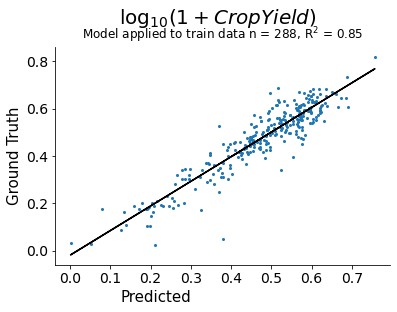

In [64]:
y_pred = np.maximum(ridge_cv_random.predict(x_train), 0)

plt.figure()
plt.scatter(y_pred, y_train, alpha=1, s=4)
plt.xlabel("Predicted", fontsize=15, x = .3)
plt.ylabel("Ground Truth", fontsize=15)
plt.suptitle(r"$\log_{10}(1 + Crop Yield)$", fontsize=20, y=1.02)
plt.title((f"Model applied to train data n = {len(x_train)}, R$^2$ = {(r2_score(y_train, y_pred)):0.2f}"),
          fontsize=12, y=1.01)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

m, b = np.polyfit(y_pred, y_train, 1)
plt.plot(y_pred, m * y_pred + b, color="black")
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

# plt.savefig(f'images/{feature_file_name}_train_data.jpg', dpi=300)
plt.show()
plt.close()

In [65]:
print(f"Training R^2 = {r2_score(y_train, y_pred):0.2f}\nPearsons R = {pearsonr(y_pred, y_train)[0]:0.2f}") 

Training R^2 = 0.85
Pearsons R = 0.93


### Test set

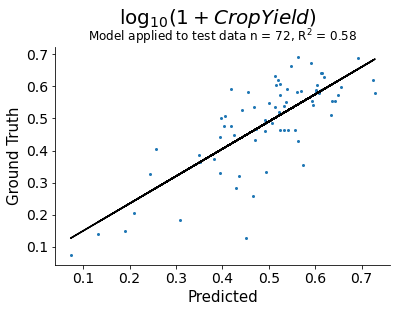

In [66]:
y_pred = np.maximum(ridge_cv_random.predict(x_test), 0)

plt.figure()
plt.scatter(y_pred, y_test, alpha=1, s=4)
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("Ground Truth", fontsize=15)
plt.suptitle(r"$\log_{10}(1 + Crop Yield)$", fontsize=20, y=1.02)
plt.title(f"Model applied to test data n = {len(x_test)}, R$^2$ = {(r2_score(y_test, y_pred)):0.2f}",
          fontsize=12, y=1)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

m, b = np.polyfit(y_pred, y_test, 1)
plt.plot(y_pred, m * y_pred + b, color="black")
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

# plt.savefig(f'images/{feature_file_name}_test_data.jpg', dpi=300)
plt.show()
plt.close()

In [67]:
print(f"Testing set R^2 = {r2_score(y_test, y_pred):0.2f}")
print(f"Testing set pearsons R = {pearsonr(y_pred, y_test)[0]:0.2f}")

Testing set R^2 = 0.58
Testing set pearsons R = 0.78


### Plot the fitted features

In [68]:
pred_features = features_copy.copy()

In [70]:
x_all = pred_features.drop([
    'year', 
    'geometry',
    'district',
    'crop_perc'
], axis = 1)
pred_features['fit'] = np.maximum(ridge_cv_random.predict(x_all), 0)

In [72]:
pred_features = geopandas.GeoDataFrame(pred_features)

In [73]:
pred_features['fit'].mask(pred_features['crop_perc']==0, 0, inplace=True)
# pred_features.loc[pred_features["crop_perc"] == 0, "fit"] = 0   ### Does same thing but differently

In [74]:
# pred_features = pred_features[pred_features.crop_perc > 0].reset_index(drop = True)

In [75]:
pred_features['fit'].mask(pred_features['fit'] > 2, 0, inplace=True)

In [77]:
plot_features = pred_features[pred_features.year == 2018]
# plot_features

<AxesSubplot:>

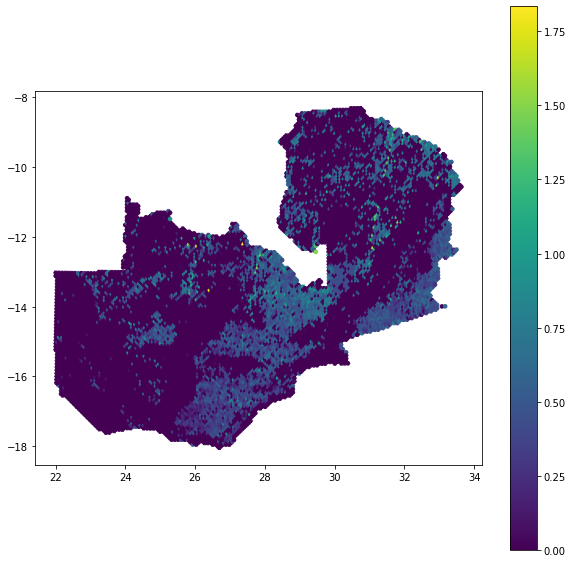

In [78]:
plot_features.plot(figsize = (10,10),
                   marker='H',
                   legend = True,
                   markersize = marker_sz,
#                    alpha = .9,
                   column = 'fit')

## Yield and Residual Plots
### Create data frame 

In [80]:
x_all = features_summary.drop([
    'district', 
    'year', 
    'yield_mt',
    'crop_perc'
], axis = 1)

residual_df = pd.DataFrame()

residual_df["yield_mt"] = features_summary.yield_mt.to_numpy()
residual_df["log_yield"] = np.log10(features_summary.yield_mt.to_numpy() + 1)
residual_df["prediction"] = np.maximum(ridge_cv_random.predict(x_all), 0)
residual_df["residual"] = residual_df["log_yield"] - residual_df["prediction"]
residual_df["year"] = features_summary.year
residual_df["district"] = features_summary.district
residual_df = residual_df.join(country_shp, how = "left", on = "district")
#demean by location
residual_df["district_yield_mean"] = residual_df.groupby('district')['log_yield'].transform('mean')
residual_df["district_prediction_mean"] = residual_df.groupby('district')['prediction'].transform('mean')
residual_df["demean_yield"] = residual_df["log_yield"] - residual_df["district_yield_mean"]
residual_df["demean_prediction"] = residual_df["prediction"] - residual_df["district_prediction_mean"]
residual_gdf = geopandas.GeoDataFrame(residual_df)
# residual_gdf

### Crop yield histogram

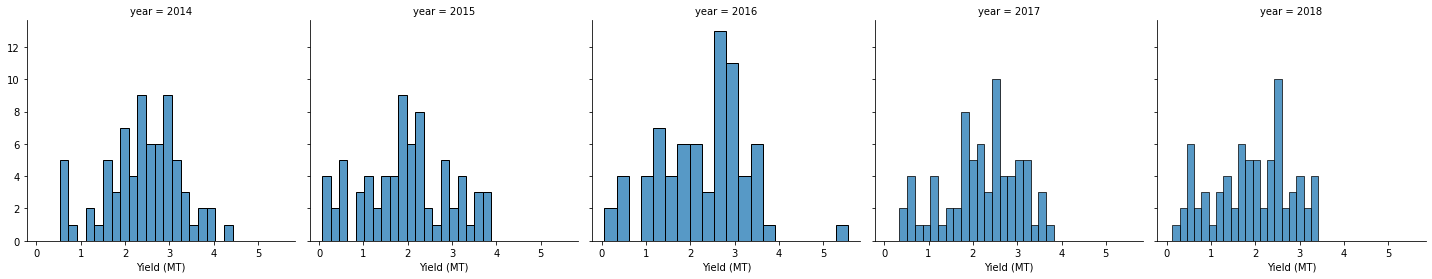

In [81]:
g = sns.FacetGrid(
    residual_gdf, 
    col="year", 
#     col_wrap = 3, 
    height=4, 
    aspect=1
)
g.map(sns.histplot, "yield_mt", bins = 20)
g.set_axis_labels("Yield (MT)")

### Log transform crop yield histogram

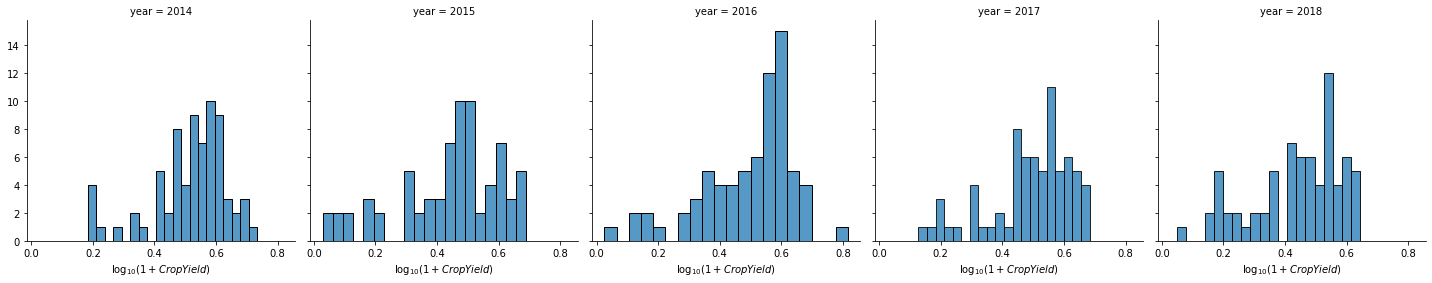

In [82]:
g = sns.FacetGrid(
    residual_gdf, 
    col="year", 
#     col_wrap = 3, 
    height=4, 
    aspect=1
)
g.map(sns.histplot, "log_yield", bins = 20)
g.set_axis_labels(r"$\log_{10}(1 + Crop Yield)$")

### Crop prediction histogram

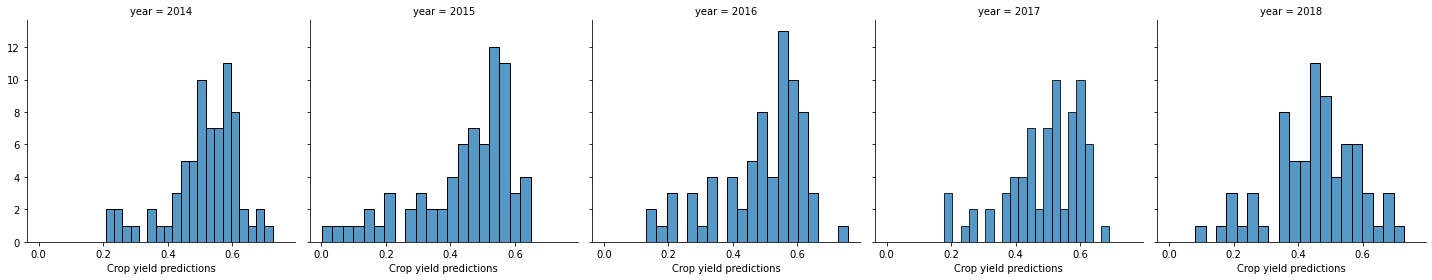

In [95]:
g = sns.FacetGrid(
    residual_gdf, 
    col="year", 
#     col_wrap = 3, 
    height=4, 
    aspect=1
)
g.map(sns.histplot, "prediction", bins = 20)
g.set_axis_labels(r"Crop yield predictions")

### Residual histogram

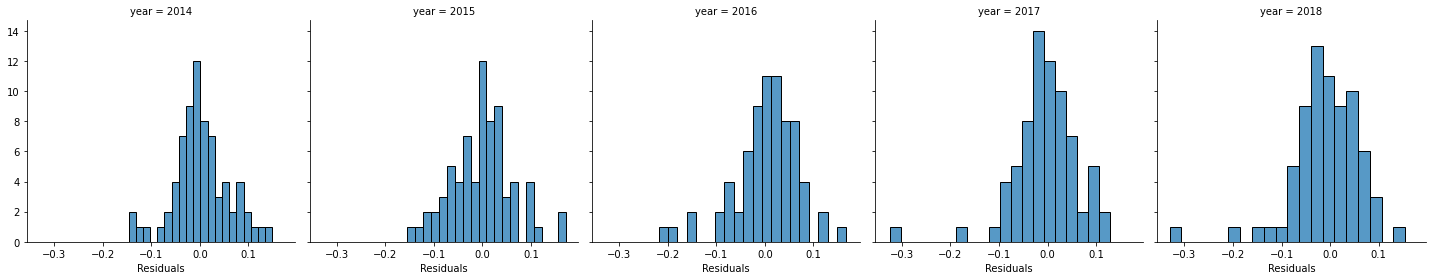

In [88]:
g = sns.FacetGrid(
    residual_gdf, 
    col="year", 
#     col_wrap = 3, 
    height=4, 
    aspect=1
)
g.map(sns.histplot, "residual", bins = 20)
g.set_axis_labels(r"Residuals")

In [89]:
residual_gdf.residual.min()

-0.3307768538771767

In [90]:
residual_gdf.residual.max()

0.17152623430322533

### Log rop yield vs residuals

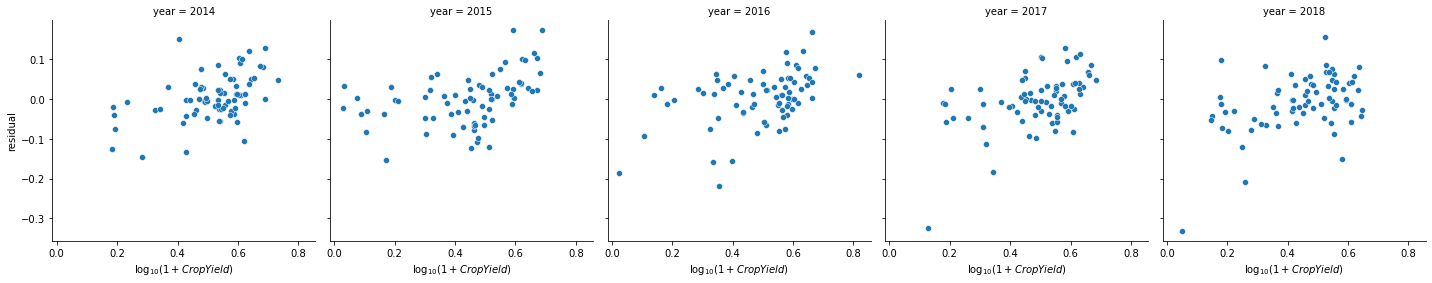

In [83]:
g = sns.FacetGrid(
    residual_gdf, 
    col="year", 
#     col_wrap = 3, 
    height=4, 
    aspect=1
)
g.map(sns.scatterplot, "log_yield", "residual")
g.set_axis_labels(r"$\log_{10}(1 + Crop Yield)$")

### District residuals

Text(0.5, 0.01, 'A positive value is an underestimated prediction (the prediction is lower than the actual yield), a negative value is an over estimated prediction')

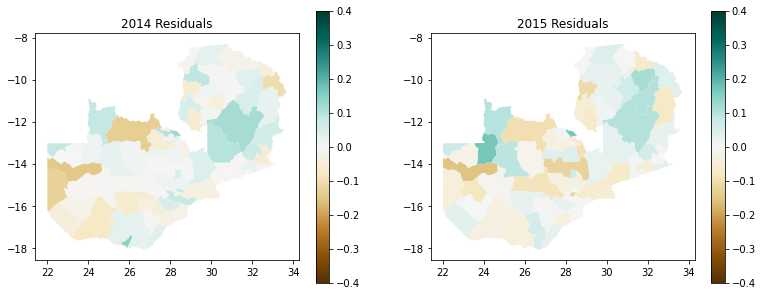

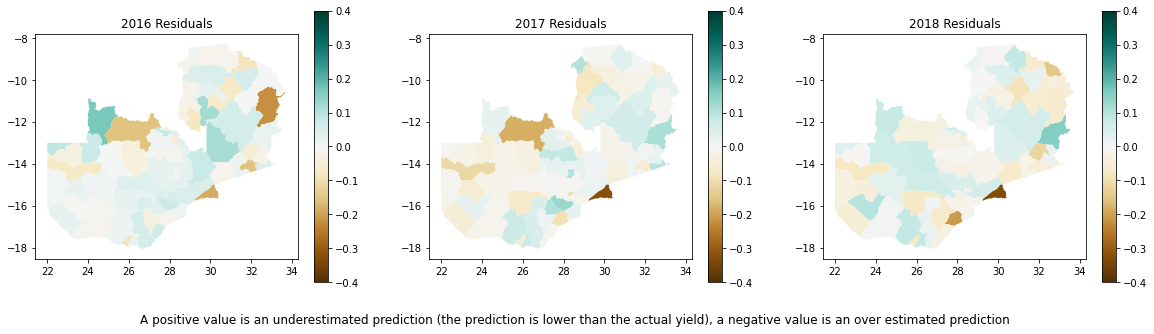

In [87]:
if satellite == 'landsat-8-c2-l2':
    fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
    ax1 = (residual_gdf[residual_gdf.year == 2014]
           .plot(ax = ax1, column = "residual", legend = True, norm=colors.Normalize(vmin= -0.4, vmax=0.4), cmap = "BrBG")
           .set_title("2014 Residuals"))
    ax2 = (residual_gdf[residual_gdf.year == 2015]
           .plot(ax = ax2, column = "residual", legend = True, norm=colors.Normalize(vmin= -0.4, vmax=0.4), cmap = "BrBG")
           .set_title("2015 Residuals"))
else:
    pass
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
ax1 = (residual_gdf[residual_gdf.year == 2016]
       .plot(ax = ax1, column = "residual", legend = True, norm=colors.Normalize(vmin= -0.4, vmax=0.4), cmap = "BrBG")
       .set_title("2016 Residuals"))
ax2 = (residual_gdf[residual_gdf.year == 2017]
       .plot(ax = ax2, column = "residual", legend = True, norm=colors.Normalize(vmin= -0.4, vmax=0.4), cmap = "BrBG")
       .set_title("2017 Residuals"))
ax3 = (residual_gdf[residual_gdf.year == 2018]
       .plot(ax = ax3, column = "residual", legend = True, norm=colors.Normalize(vmin= -0.4, vmax=0.4), cmap = "BrBG")
       .set_title("2018 Residuals"))

caption = "A positive value is an underestimated prediction (the prediction is lower than the actual yield), a negative value is an over estimated prediction"
plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=12)

### Difference from the Mean

In [91]:
residual_gdf_2016 = residual_gdf[residual_gdf.year == 2016]
residual_gdf_2017 = residual_gdf[residual_gdf.year == 2017]
residual_gdf_2018 = residual_gdf[residual_gdf.year == 2018]

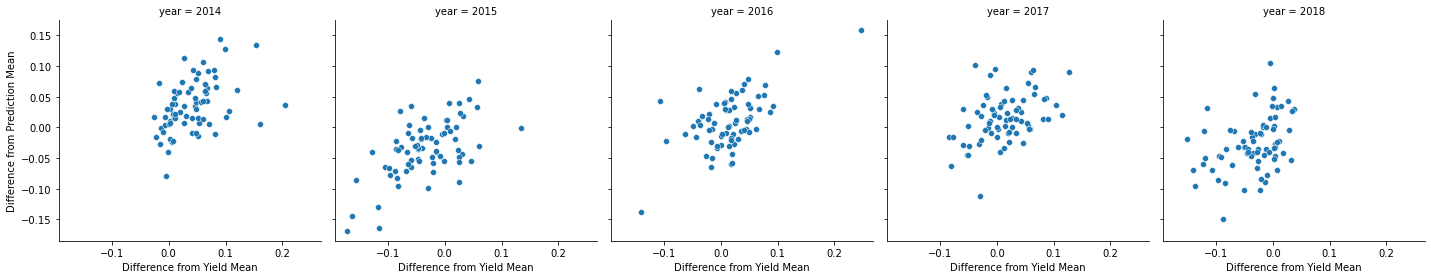

In [92]:
g = sns.FacetGrid(
    residual_gdf, 
    col="year", 
#     col_wrap = 3, 
    height=4, 
    aspect=1
)
g.map(sns.scatterplot, "demean_yield", "demean_prediction")
g.set_axis_labels('Difference from Yield Mean', 'Difference from Prediction Mean')

Text(0, 0.5, 'Difference from Predictions Mean')

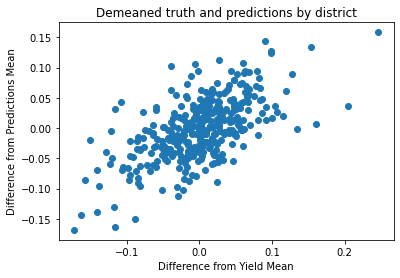

In [93]:
plt.scatter(residual_gdf.demean_yield, residual_gdf.demean_prediction)
plt.title("Demeaned truth and predictions by district")
plt.xlabel('Difference from Yield Mean')
plt.ylabel('Difference from Predictions Mean')

In [94]:
for yr in range(year_start+1, year_end+1):
    r_squared = r2_score(residual_gdf[residual_gdf.year == yr]["demean_yield"], residual_gdf[residual_gdf.year == yr]["demean_prediction"])
    pearson_r = pearsonr(residual_gdf[residual_gdf.year == yr]["demean_yield"], residual_gdf[residual_gdf.year == yr]["demean_prediction"])
    
    print(yr, f"    R^2: {r_squared:.2f}\n",
          f"Pearson's R: {pearson_r[0]:.2f}\n", 
          sep = "")
    
r_squared = r2_score(residual_gdf["demean_yield"], residual_gdf["demean_prediction"])
pearson_r = pearsonr(residual_gdf["demean_yield"], residual_gdf["demean_prediction"])
print(f"All     R^2: {r_squared:.2f}\n",
      f"Pearson's R: {pearson_r[0]:.2f}", sep = "")

2014    R^2: -0.12
Pearson's R: 0.43

2015    R^2: 0.31
Pearson's R: 0.60

2016    R^2: 0.27
Pearson's R: 0.59

2017    R^2: -0.02
Pearson's R: 0.41

2018    R^2: -0.21
Pearson's R: 0.39

All     R^2: 0.33
Pearson's R: 0.63
